In [1]:
import os
import sys
sys.path.append("../")
import csv
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import settings
from process_sentinel3 import OLCIdata, OLCIdataGenerator

### Define variables

In [2]:
DATA_PATH = settings.processed_data_path
algae_gt_path = os.path.join(settings.final_data_path, "algae_gt.csv")
DATE_FORMAT = '%Y-%m-%d'

#contorno interno lat/lon
INTERNAL_CONTOUR = [[-34.85044049, -55.05341557], [-34.85254593, -55.06282895], [-34.84523452, -55.07215948], 
                    [-34.84214073, -55.08336897], [-34.83733203, -55.08595825], [-34.830501, -55.07932854], 
                    [-34.82322889, -55.07377278], [-34.81443658, -55.06745663], [-34.80518264, -55.06063834], 
                   [-34.79828906, -55.05565486], [-34.79200075, -55.04700809], [-34.80233605, -55.04418996],
                   [-34.81042967, -55.04493995], [-34.82011843, -55.04664643], [-34.82953074, -55.04855582],
                   [-34.83996726, -55.0500401], [-34.85044049, -55.05341557]]
# lon/lat
INTERNAL_CONTOUR_2 = [[coord[1], coord[0]] for coord in INTERNAL_CONTOUR]

## Read CSV containing GT into a DataFrame

In [3]:
algae_df = pd.read_csv(algae_gt_path)
all_gt_dates = algae_df.date.unique()
print(all_gt_dates)
print(f"Total dates in GT: {len(all_gt_dates)}")
algae_df

['2015-12-30' '2016-01-07' '2016-01-13' '2016-01-23' '2016-01-27'
 '2016-02-03' '2016-02-10' '2016-02-18' '2016-02-24' '2016-03-02'
 '2016-03-10' '2016-03-22' '2016-03-29' '2016-04-07' '2016-12-01'
 '2016-12-09' '2016-12-16' '2016-12-22' '2017-01-02' '2017-01-11'
 '2017-01-18' '2017-01-24' '2017-02-02' '2017-02-08' '2017-02-15'
 '2017-02-22' '2017-03-01' '2017-03-08' '2017-03-23' '2017-03-31'
 '2017-04-07' '2017-12-07' '2017-12-28' '2018-01-03' '2018-01-11'
 '2018-01-18' '2018-01-25' '2018-01-31' '2018-02-08' '2018-02-15'
 '2018-02-22' '2018-03-01' '2018-03-07' '2018-03-26' '2018-04-05'
 '2018-04-18' '2018-11-13' '2018-11-20' '2018-11-30' '2018-12-13'
 '2018-12-20' '2018-12-28' '2019-01-04' '2019-01-11' '2019-01-18'
 '2019-01-24' '2019-01-31' '2019-02-07' '2019-02-15' '2019-02-21'
 '2019-03-01' '2019-03-07' '2019-03-14' '2019-03-22' '2019-03-29'
 '2019-04-04' '2019-04-12' '2019-05-18' '2019-08-01' '2019-09-22'
 '2019-11-06' '2019-11-15' '2019-11-27' '2019-12-13' '2019-12-23'
 '2019-12-

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.50,10.00,No Bloom
1,2015-12-30,ARROYO SAUCE,5345.50,21.80,No Bloom
2,2015-12-30,SAUCE NORTE,4282.50,7.50,No Bloom
3,2015-12-30,SAUCE SUR,5388.00,7.50,No Bloom
4,2015-12-30,CISNES,9082.50,18.45,Bloom
...,...,...,...,...,...
685,2020-10-31,TA,1083.00,NaN,No Bloom
686,2020-11-01,TA,47.00,NaN,No Bloom
687,2020-11-02,TA,5.96,NaN,No Bloom
688,2020-11-05,TA,9.06,NaN,No Bloom


### Satellite availability

In [4]:
first_sentinel3_date = "2018-11-01"
gt_last_date = all_gt_dates[-1]
gt_first_date = all_gt_dates[0]

In [5]:
data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, dates_list=all_gt_dates.tolist(), skip_invalid=False,
                                  mask_coordinates=INTERNAL_CONTOUR_2)

data_generator_skip_invalid = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, dates_list=all_gt_dates.tolist(), skip_invalid=True,
                                  mask_coordinates=INTERNAL_CONTOUR_2)

In [6]:
count = 0
for d in data_generator_skip_invalid:
    count += 1
print(count)

82


In [6]:
fico_df_after_s3b = algae_df[algae_df["date"] >= first_sentinel3_date]

s3_all = list(set([d.date.date() for d in data_generator \
                               if d.date >= datetime.strptime(first_sentinel3_date, "%Y-%m-%d") and d.date <= datetime.strptime(gt_last_date, "%Y-%m-%d")]))
satellite_acquisition_rate = round(len(s3_all)/len(fico_df_after_s3b["date"].unique()),2)
print(f"Sentinel-3 acquisition rate: {satellite_acquisition_rate}")

s3_skip_invalid = list(set([d.date.date() for d in data_generator_skip_invalid \
                                            if d.date >= datetime.strptime(first_sentinel3_date, "%Y-%m-%d") and d.date <= datetime.strptime(gt_last_date, "%Y-%m-%d")]))
satellite_acquisition_clear =  round(len(s3_skip_invalid)/len(fico_df_after_s3b["date"].unique()), 2)
print(f"Sentinel-3 acquisition without clouds: {satellite_acquisition_clear}")

Sentinel-3 acquisition rate: 0.99
Sentinel-3 acquisition without clouds: 0.34


## Trophic state detection

In [7]:
sampling_points_coords = {"SAUCE NORTE": [-34.795398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          "TA": [-34.829670, -55.049758]}

In [20]:
# create generator that yields instances of OLCIdata from dates with ground truth
# data corrupted by clouds is skipped
data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, dates_list=all_gt_dates.tolist(), skip_invalid=True)

y_gt = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

y_pred = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

for olci_data in data_generator:
    # get gt data for same date as OLCI data
    day_fico_df = algae_df[algae_df["date"] == str(olci_data.date.date())]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in y_gt):
            continue
        olci_data._get_mph(0)
        olci_data.create_sparse_mask([sampling_points_coords[row["location"]]])
        
        immersed_mask = olci_data.mph.immersed_cyanobacteria*olci_data.mask
        count_immersed = np.count_nonzero(immersed_mask)
        
        floating_mask = olci_data.mph.floating_cyanobacteria*olci_data.mask
        count_floating = np.count_nonzero(olci_data.mph.floating_cyanobacteria*olci_data.mask)
        
        count_total = count_immersed + count_floating

        y_pred[row["location"]].append(count_total > 0)
        y_gt[row["location"]].append(True if row["label"] == "Bloom" else False)

SAUCE NORTE
Accuracy: 0.85
Precision: 0.6
Recall: 1.0
FPR: 0.0
FNR: 0.2


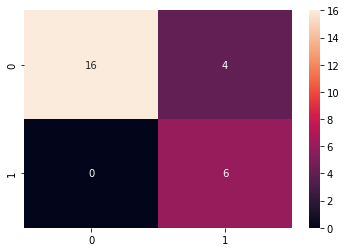

SAUCE SUR
Accuracy: 0.88
Precision: 0.73
Recall: 1.0
FPR: 0.0
FNR: 0.17


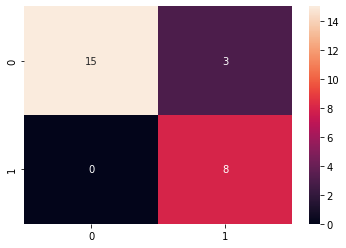

TA
Accuracy: 0.86
Precision: 0.77
Recall: 1.0
FPR: 0.0
FNR: 0.26


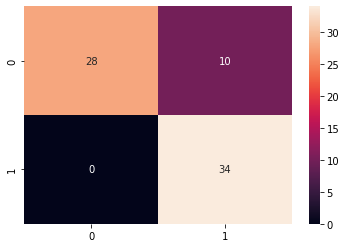

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def metrics(gt, pred):
    metrics = {}
    metrics["accuracy"] = round(accuracy_score(gt, pred), 2)
    metrics["precision"] = round(precision_score(gt, pred), 2)
    metrics["recall"] = round(recall_score(gt, pred), 2)
    metrics["confusion matrix"] = confusion_matrix(gt, pred)
    metrics["false positive rate"] = round(metrics["confusion matrix"][1, 0]/(metrics["confusion matrix"][1, 1] + metrics["confusion matrix"][1, 0]), 2)
    metrics["false negative rate"] = round(metrics["confusion matrix"][0, 1]/(metrics["confusion matrix"][0, 0] + metrics["confusion matrix"][0, 1]), 2)
    
    return metrics

for location in list(y_gt.keys()):
    print(location)
    m = metrics(y_gt[location], y_pred[location])
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

### Create dataset using MPH input bands 

In [13]:
sentinel3_dataset_path = os.path.join(settings.final_data_path, "s3_brrs.json")

In [14]:
sentinel3_dataset = []
data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, skip_invalid=False)
bands_names = ["rBRR_07", "rBRR_08", "rBRR_10", "rBRR_11", "rBRR_12", "rBRR_18"]

for olci_data in data_generator:
    dataset_entry = {}
    dataset_entry["date"] = str(olci_data.date.date())
    
    # set None as default for every sampling location data
    for location_name in sampling_points_coords.keys():
        dataset_entry[location_name] = {b_name: None for b_name in bands_names}
    
    # skip further processing for dates with clouds
    if olci_data.metadata["cloud level"] != "0":
        sentinel3_dataset.append(dataset_entry)
        continue
    
    # store 3x3 array of every band around location coords for days without clouds
    for location_name, location_coords in sampling_points_coords.items():
        i, j = olci_data.get_pos_index(location_coords[0], location_coords[1])
        for b_name in bands_names:
            dataset_entry[location_name][b_name] = olci_data.brrs_arrays[b_name][i-1:i+2, j-1:j+2].tolist()
    sentinel3_dataset.append(dataset_entry)
    

In [16]:
sentinel3_dataset[0:5]

[{'date': '2018-11-01',
  'SAUCE NORTE': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None},
  'SAUCE SUR': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None},
  'TA': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None}},
 {'date': '2018-11-01',
  'SAUCE NORTE': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None},
  'SAUCE SUR': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None},
  'TA': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None}},
 {'date': '2018-11-02',
  'SAUCE NORTE': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': Non

In [17]:
import json

with open(sentinel3_dataset_path, "w") as outfile:
    json.dump(sentinel3_dataset, outfile)